<a href="https://colab.research.google.com/github/datamino/PINNs/blob/main/case1_p1_(LOHF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
from torchinfo  import summary
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
'''
Differntial Equation => dy/dx=2x
Inital Condition     =>  y(0)=1
Solution of DE       =>     y=x**2 +1

'''
def true_solution(x):
     return torch.pow(x,2)+1

In [5]:
class PINN(nn.Module):
  def __init__(self,n_features=1):
    super().__init__()
    self.net=nn.Sequential(
           nn.Linear(n_features,100),
           nn.Tanh() ,
           nn.Linear(100,100),
           nn.Sigmoid() ,
           nn.Linear(100,1),

    )

  def forward(self,X):
       return self.net(X)



In [6]:
model=PINN()

In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
PINN                                     --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       200
│    └─Tanh: 2-2                         --
│    └─Linear: 2-3                       10,100
│    └─Sigmoid: 2-4                      --
│    └─Linear: 2-5                       101
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0

In [8]:
def loss(model,x):
    x.requires_grad=True
    y=model(x)
    dy_dx=torch.autograd.grad(y,x,torch.ones_like(y),create_graph=True)[0]
    equation_loss = torch.mean((dy_dx - (2*x)) ** 2)
    x0=torch.tensor([[0.0]])
    y0=model(x0)
    initial_loss= (y0 - 1) ** 2
    total_loss=equation_loss+initial_loss
    return total_loss


In [9]:
optimizer=optim.SGD(model.parameters(),lr=0.01)

Epoch 1/5000, Loss: 6.394002914428711
Epoch 1001/5000, Loss: 0.01710064336657524
Epoch 2001/5000, Loss: 0.006657841615378857
Epoch 3001/5000, Loss: 0.0050871712155640125
Epoch 4001/5000, Loss: 0.0041027795523405075


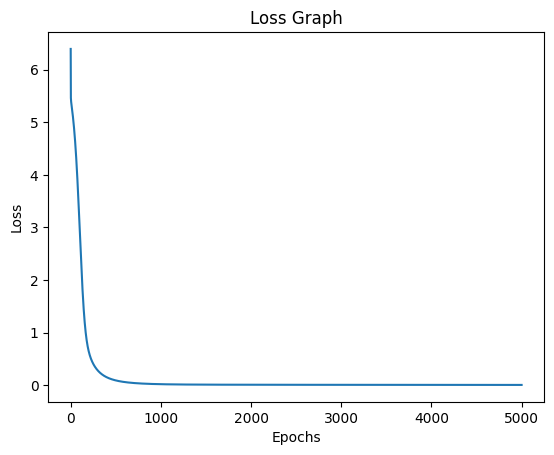

In [10]:
X_train=torch.linspace(-2,2,100).view(-1,1)
epochs=5000

loss_history=[]
for epoch in range(epochs):
       optimizer.zero_grad()
       loss_=loss(model,X_train)
       loss_.backward()
       loss_history.append(loss_.item())
       if epoch%1000==0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss(model,X_train).item()}')
       optimizer.step()

plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.show()

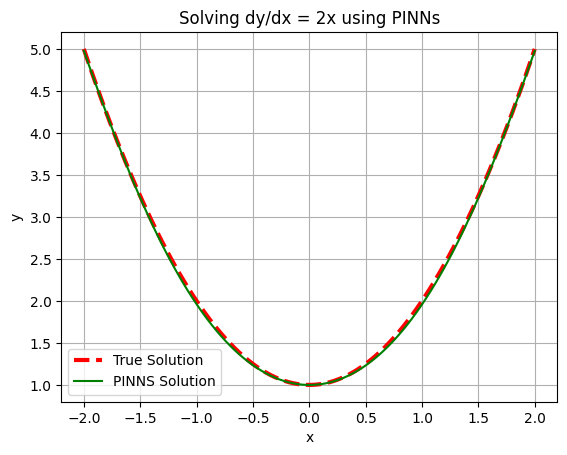

In [11]:
X_test = torch.linspace(-2, 2, 100).view(-1, 1)
y_pred = model(X_test).detach().numpy()

plt.plot(X_test,true_solution(X_test),linestyle="dashed",linewidth=3,label="True Solution",color="red")
plt.plot(X_test,y_pred,label="PINNS Solution",color="green")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Solving dy/dx = 2x using PINNs')
plt.grid()
plt.show()
